<a href="https://colab.research.google.com/github/yilin10/MusicalGenreClassification/blob/master/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Music Languages and System - Assignment 1

## Imports

Import of **Libraries**

In [0]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import sklearn.svm
import IPython.display as ipd
import scipy as sp

Upload of your personal **Kaggle Api token** to enable download from Kaggle

In [0]:
from google.colab import files
files.upload() # Choose kaggle.json (your personal Kaggle API token)

! rm -r ~/.kaggle
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json # Change the permissions of the file.

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory


Download of the dataset from Kaggle

In [0]:
! pip install -q kaggle
! mkdir ~/dataset
! kaggle datasets download -d carlthome/gtzan-genre-collection
! unzip -q gtzan-genre-collection.zip -d ~/dataset

 99% 1.13G/1.14G [00:09<00:00, 105MB/s]
100% 1.14G/1.14G [00:09<00:00, 129MB/s]


We can get the dataset from kaggle, which includes 100 pieces of 30s audio from 10 different music genres provided by GTZAN. All the audio tracks are sampled at 22050 Hz Mono 16-bit audio files in .au format.

And in our task we need to classify Blues, Metal, Hip-Hop, Reggae.

## Playground 1(Test 0410 )

This part is not useful, just try to play with the dataset we have in order to get familiar with how to extract the needed features.

First, I am trying to play with Library librosa with a simple audio file.


In [0]:
path = "../root/dataset/genres/blues/blues.00000.au"
y, sr = librosa.load(path) # samplerate
#c_path = librosa.util.example_audio_file()
#sample_rate = librosa.get_samplerate(c_path)

tempo, beat_frames = librosa.beat.beat_track(y, sr)

f_mfcc = librosa.feature.mfcc(y, sr)
duration = librosa.get_duration(y, sr)
rms = librosa.feature.rms(y)
mels = librosa.feature.melspectrogram(y,sr) #calculate the melspectrogram


print("current file: ", path, "with sample rate: ", sr) # 
#print("y = ", y)
print('The Estimated tempo is : {:.2f} beats per minute'.format(tempo))
print("mfcc = ", f_mfcc)
print("The duration of the file is: ", duration, "in seconds")
print("RMS: ", rms)
print("MELS: ", mels)


/usr/local/lib/python3.6/dist-packages/librosa/beat.py:306: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  hop_length=hop_length))


current file:  ../root/dataset/genres/blues/blues.00000.au with sample rate:  22050
The Estimated tempo is : 123.05 beats per minute
mfcc =  [[-211.48465086 -208.94482648 -193.90886432 ... -109.99914277
   -86.84641504  -79.03764389]
 [  99.02296527  101.24677684  102.2439539  ...  150.07934372
   138.89685143  140.24707739]
 [ -10.63469419   -9.34669827    1.91543412 ...  -50.79513665
   -36.61398204  -31.44394114]
 ...
 [   8.94441077    6.88274853    3.65002299 ...   -2.85715698
    -6.25478926   -0.48850937]
 [   3.07485139    4.56672571    4.78899975 ...   -7.57468805
    -8.44005951   -7.88065949]
 [   5.04152675    2.8966338     0.94024655 ...   -7.55533868
     0.29069301    2.65881555]]
The duration of the file is:  30.013333333333332 in seconds
RMS:  [[0.02698701 0.03934191 0.0497628  ... 0.1405525  0.13533325 0.14893965]]
MELS:  [[3.52039269e+00 1.84593385e+00 7.44535793e-01 ... 2.23298189e+00
  2.25105209e+00 1.91527191e+01]
 [2.63766960e+00 3.33343668e+00 5.02164405e+00 ..

What we can get from the sample audio file as **general information**,
1. basic info: sample rate, duration of the file,estimated tempo
2. low level feature info
3. high level feature info


I want to calculate and analysis the following,
1. MFCC - current
2. RMS/Zero crossing rate
3. MELS
4. other...

using the four categories{Blues, Metal, Hip-hop, Reggae} as instructed.

In [34]:
#we need to analysis Blues, Metal, Hip-Hop, Reggae
ana_class = ["blues","metal","hiphop","reggae"] 
dict_train_features = {"blues": [], "metal": [], "hiphop": [], "Reggae": []}
n_mfcc = 20 
# but why 13?
train_path = "../root/dataset/genres/"


for each in ana_class:
    train_test_folder = train_path + format(each)
    #the current folder/categories
    print("Current train_test_folder is: " + train_test_folder)

    train_catg_files = [f for f in os.listdir(train_test_folder) if f.endswith('.au')]
    #print(train_catg_files)
    n_train_samples = len(train_catg_files) 
    #how much files in each category
    print("Number of training samples in this category: ", n_train_samples)
    
    #store feature result
    train_features = np.zeros((n_train_samples, n_mfcc))
    
    #print(train_features)
    for index, each_file in enumerate(train_catg_files):
        each_file_path = os.path.join(train_test_folder, each_file)
        y, sr = librosa.load(each_file_path)
        feature_mfcc = librosa.feature.mfcc(y, sr)
        train_features[index, :] = np.mean(feature_mfcc, axis=1)
        #print("train_features", train_features)
        #dont need tempo in this way, for now...
        #tempo, beat_frames = librosa.beat.beat_track(y, sr)
        #print("Estimated tempo: ", tempo)

    dict_train_features[each] = train_features
    print(dict_train_features["blues"])

Current train_test_folder is: ../root/dataset/genres/blues
Number of training samples in this category:  100
[[-1.21448978e+02  9.60805375e+01 -1.95898421e+01 ... -2.04378116e+00
  -1.76269026e+00 -3.96245312e+00]
 [-1.21363940e+02  1.22506683e+02 -1.47381965e+01 ...  2.69524786e+00
   3.41230547e+00 -2.71569238e+00]
 [-3.00981873e+01  1.03732518e+02 -1.97379711e+01 ...  4.72184211e+00
   4.90646799e-01  1.47166699e+00]
 ...
 [-1.55558833e+02  1.25645326e+02  1.60112256e+00 ...  9.69413886e-01
   2.02691569e+00 -5.73704447e+00]
 [-1.45280972e+02  1.02806649e+02 -1.25294329e+01 ... -9.52051838e-01
   2.25845906e-02 -2.00456166e+00]
 [-5.26972475e+01  7.44333591e+01 -1.86967667e+01 ...  3.68983828e+00
  -4.93847515e+00  4.42173063e+00]]
Current train_test_folder is: ../root/dataset/genres/metal
Number of training samples in this category:  100
[[-1.21448978e+02  9.60805375e+01 -1.95898421e+01 ... -2.04378116e+00
  -1.76269026e+00 -3.96245312e+00]
 [-1.21363940e+02  1.22506683e+02 -1.4738

**Visulise the features of MFCC**


Something seems wrong...

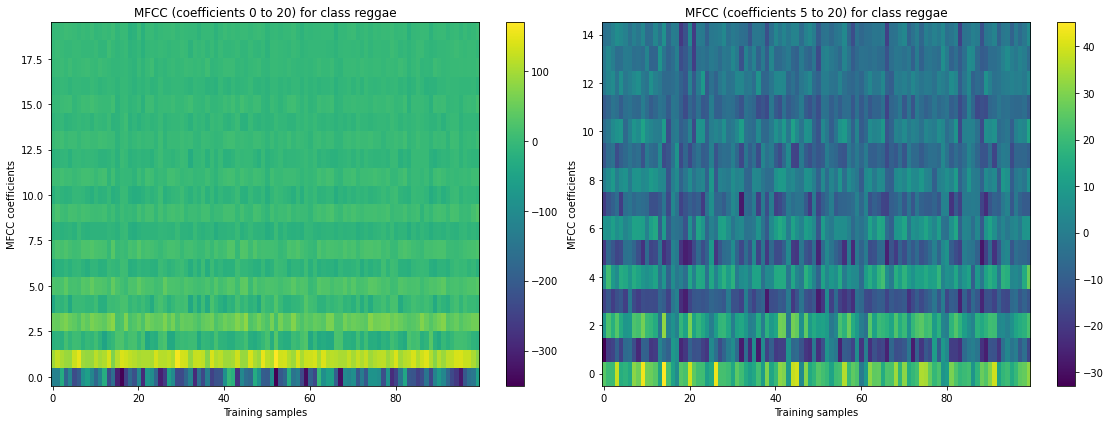

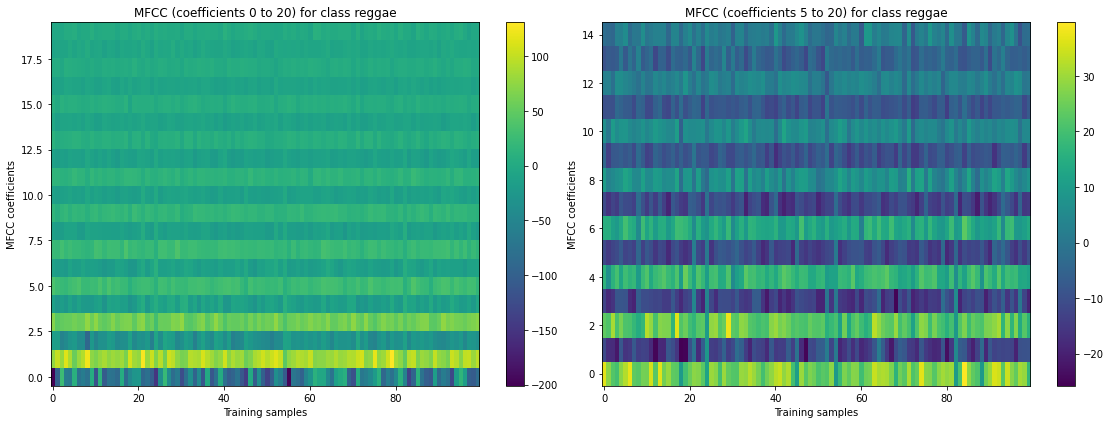

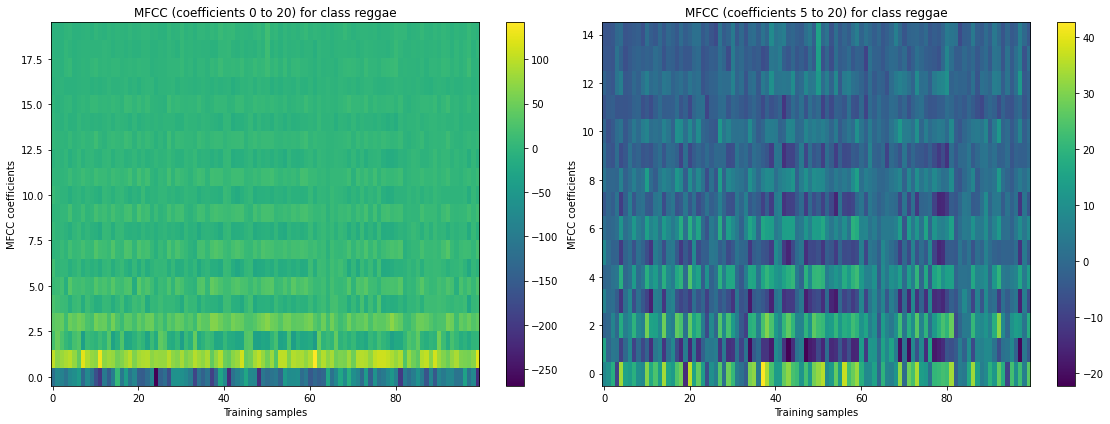

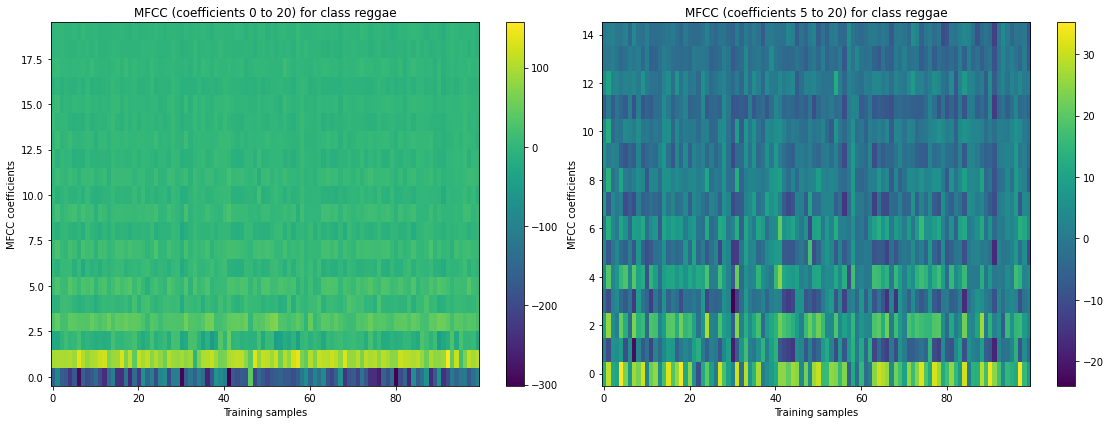

In [37]:
for each in ana_class:
    mfcc = dict_train_features[each].transpose()
    
    # Visualization
    figure = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 20) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()

    mfcc_upper = mfcc[5:]
    plt.subplot(1,2,2)
    plt.imshow(mfcc_upper, origin='lower', aspect='auto')
    plt.title('MFCC (coefficients 5 to 20) for class {}'.format(c))
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()
    plt.tight_layout()

## COMMIT TEST

In [0]:
#Yilin

#Silvio
#Mattia
#Lorenzo

## Team Discussion
1. apply preprocessing to audio files
2. how to split our dataset to {training, testing} to make sure the difference of the two groups
3. check if our dataset is balanced? Actually it is already balanced.
4. which set of features can to useful for our cases
5. apply feature selection?
6. choose which classification method?
7. try different parameter for the classfier
8. evaluate the model
9. display the result

## Training

## Testing


## Optimization

## Conclusion